In [ ]:
# In this challenge, you will predict healthcare costs using a regression algorithm.

# You are given a dataset that contains information about different people including their healthcare costs. Use the data to predict healthcare costs based on new data.

# The first two cells of this notebook import libraries and the data.

# Make sure to convert categorical data to numbers. Use 80% of the data as the train_dataset and 20% of the data as the test_dataset.

# pop off the "expenses" column from these datasets to create new datasets called train_labels and test_labels. Use these labels when training your model.

# Create a model and train it with the train_dataset. Run the final cell in this notebook to check your model.
# The final cell will use the unseen test_dataset to check how well the model generalizes.

# To pass the challenge, model.evaluate must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.

# The final cell will also predict expenses using the test_dataset and graph the results.

In [ ]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

  Preparing metadata (setup.py) ... done
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2023-10-10 00:00:20--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv.1’

insurance.csv.1     100%[===================>]  49.09K  --.-KB/s    in 0.007s  

2023-10-10 00:00:20 (6.48 MB/s) - ‘insurance.csv.1’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [ ]:
#First Steps, see the dataset
print('Info about Dataset')
dataset.info()

print('Dataset description')
dataset.describe()

Info about Dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
Dataset description


,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


In [ ]:
from pandas.core.arraylike import default_array_ufunc
print('No NAN values. Columns Sex, Smoker and Region needs transformation.')
df = pd.get_dummies(dataset, columns=['sex'])
#Created two columns with binary values. Keep only one and use a linear model with intercept
df = df.drop(['sex_female'], axis = 1).rename(columns = {'sex_male':'sex'})

df = pd.get_dummies(df, columns=['smoker'])
#For smoker feature, use the same approach and keep only one binary column
df = df.drop(['smoker_no'], axis = 1).rename(columns = {'smoker_yes':'smoker'})

#Create a few Features, like mix Dummie and others
df['Dummy_Sex_Smoker'] = df['sex']*df['smoker']


print(df.shape)
print(df.head())
print('Dataset Ready to be split on train and test. Recalling that it not a time series, so it does not matter the order of the rows, it can be shuffled')



#set random seed
np.random.seed(42)

#Setting split ratio and splitting data
split_ratio = 0.8

# Calculate the number of samples for the training set
num_samples = len(df)
num_train_samples = int(split_ratio * num_samples)

# Create a random permutation of indices
indices = np.random.permutation(num_samples)

# Split the indices into training and test indices
train_indices = indices[:num_train_samples]
test_indices = indices[num_train_samples:]

# Use the indices to split the data
train_dataset = df.loc[train_indices]
print('Train shape', train_dataset.shape)
test_dataset = df.loc[test_indices]
print('Test shape', test_dataset.shape)

#Check if there is duplicated data between the two sets in order to avoid any leakage
merged_df = pd.merge(test_dataset, train_dataset, on=list(test_dataset.columns), how='inner')

# Check if there are common rows
if not merged_df.empty:
    print("Common rows exist.")
else:
    print("No common rows.")

#Before region dummies
group_means_train = train_dataset.groupby('region')['expenses'].transform('mean')
train_dataset['Mean_Value_Group'] = group_means_train

# train_dataset['Ratio_Expense_On_Region'] = train_dataset['expenses']/train_dataset['Mean_Value_Group']

#getting average on test set but without leakege
df_region_mean = train_dataset[['region', 'Mean_Value_Group']].reset_index(drop=True).drop_duplicates()
print('shape antes do merge',test_dataset.shape)
test_dataset = pd.merge(test_dataset, df_region_mean, on = 'region', how = 'left')

#   test_dataset['Ratio_Expense_On_Region'] = test_dataset['expenses']/test_dataset['Mean_Value_Group']
print('shape apos merge',test_dataset.shape)
print(test_dataset.head(10))

train_dataset = pd.get_dummies(train_dataset, columns=['region'])

test_dataset = pd.get_dummies(test_dataset, columns=['region'])
#For Region features, will keep all columns and not hide information on the intercept. However it could be done.
#Drop one region

#Get Y and X split
train_labels = train_dataset.pop('expenses')
test_labels = test_dataset.pop('expenses')

print('X Train shape', train_dataset.shape)
print('Y Train shape', train_labels.shape)

print('X Test shape', test_dataset.shape)
print('Y Test shape', test_labels.shape)

print('Info about Train')
train_dataset.info()
train_dataset.describe()
print('Info about Test')
test_dataset.info()
test_dataset.describe()


No NAN values. Columns Sex, Smoker and Region needs transformation.
(1338, 8)
   age   bmi  children     region  expenses  sex  smoker  Dummy_Sex_Smoker
0   19  27.9         0  southwest  16884.92    0       1                 0
1   18  33.8         1  southeast   1725.55    1       0                 0
2   28  33.0         3  southeast   4449.46    1       0                 0
3   33  22.7         0  northwest  21984.47    1       0                 0
4   32  28.9         0  northwest   3866.86    1       0                 0
Dataset Ready to be split on train and test. Recalling that it not a time series, so it does not matter the order of the rows, it can be shuffled
Train shape (1070, 8)
Test shape (268, 8)
No common rows.
shape antes do merge (268, 8)
shape apos merge (268, 9)
   age   bmi  children     region  expenses  sex  smoker  Dummy_Sex_Smoker  \
0   45  30.5         2  northwest   8413.46    1       0                 0   
1   54  31.9         1  southeast  10928.85    0       0

,age,bmi,children,sex,smoker,Dummy_Sex_Smoker,Mean_Value_Group,region_northeast,region_northwest,region_southeast,region_southwest
count,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000
mean,38.630597,30.386194,1.067164,0.507463,0.194030,0.100746,13383.814896,0.302239,0.227612,0.283582,0.186567
std,14.375441,5.942697,1.264305,0.500880,0.396192,0.301556,839.734256,0.460087,0.420075,0.451580,0.390293
min,18.000000,16.800000,0.000000,0.000000,0.000000,0.000000,12570.615164,0.000000,0.000000,0.000000,0.000000
25%,25.750000,26.075000,0.000000,0.000000,0.000000,0.000000,12767.965720,0.000000,0.000000,0.000000,0.000000
50%,38.000000,30.500000,1.000000,1.000000,0.000000,0.000000,13136.165432,0.000000,0.000000,0.000000,0.000000
75%,51.000000,34.125000,2.000000,1.000000,0.000000,0.000000,14677.056910,1.000000,0.000000,1.000000,0.000000
max,64.000000,47.600000,5.000000,1.000000,1.000000,1.000000,14677.056910,1.000000,1.000000,1.000000,1.000000


In [ ]:
#Create Model - LGBM
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import warnings

# Ignore LightGBM specific warnings
warnings.filterwarnings('ignore', category=UserWarning, message='.*lightgbm.*')

#Create hyperparameter grid to tune
param_grid = {

    # 'num_leaves': [20, 30, 40],
    'max_depth': [5, 10,],
    'learning_rate': [0.01, 0.5],
    'n_estimators': [100, 200, 300],
    # 'subsample_for_bin': [20000, 30000, 40000],
    # 'min_child_samples': [20, 30, 40],
    # 'reg_alpha': [0.0, 0.1, 0.5],
    # 'reg_lambda': [0.0, 0.1, 0.5],
    # 'colsample_bytree': [0.6, 0.7, 0.8],
    # 'colsample_bylevel': [0.6, 0.7, 0.8],

}

# Create the LightGBM model
lgb_model = lgb.LGBMRegressor()

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')


grid_search.fit(train_dataset, train_labels)

# Access the best hyperparameters and estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)
print("Best Estimator:", best_estimator)

model = lgb.LGBMRegressor(**best_params)

# Fit the best model to the entire training data
model.fit(train_dataset, train_labels)

# Evaluate the model on the test data
y_pred = model.predict(test_dataset)
mse = mean_squared_error(test_labels, y_pred)
mae = mean_absolute_error(test_labels, y_pred)
print("Mean Squared Error on Test Data:", mse)
print("Mean Absolute Error on Test Data:", mae)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
#LINEAR REGRESSION IS NOT ABLE TO ACHIEVE METRIC ASKED

# #Create Model - Elastic Net
# from sklearn.linear_model import ElasticNet
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import mean_absolute_error
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler
# import warnings

# # Ignore warnings

# warnings.filterwarnings('ignore', category=UserWarning)
# # scaler = MinMaxScaler()
# scaler = StandardScaler()
# train_dataset_scaled = scaler.fit_transform(train_dataset)
# test_dataset_scaled = scaler.transform(test_dataset)

# train_labels_scaled = scaler.fit_transform(pd.DataFrame(train_labels))
# # test_labels_scaled = scaler.transform(pd.DataFrame(test_labels))
# # Define the hyperparameter grid for Elastic Net
# param_grid = {
#     'alpha': np.logspace(-3, 3, 20),  # Regularization strength
#     'l1_ratio': np.linspace(0, 1, 20)  # Mixing parameter between L1 and L2 regularization
# }
# #Create hyperparameter grid to tune


# elastic_net = ElasticNet()

# # Create the GridSearchCV object
# grid_search = GridSearchCV(elastic_net, param_grid, cv=10, scoring='neg_mean_absolute_error')

# # Fit the model with cross-validation
# grid_search.fit(train_dataset_scaled, train_labels_scaled)

# # Get the best hyperparameters
# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# print("Best Hyperparameters:", best_params)
# print("Best Negative Mean Squared Error:", best_score)

# model = ElasticNet(**best_params)

# # Fit the best model to the entire training data
# model.fit(train_dataset_scaled, train_labels_scaled)

# # Evaluate the model on the test data
# y_pred = model.predict(test_dataset_scaled)
# y_pred = scaler.inverse_transform(pd.DataFrame(y_pred))
# mse = mean_squared_error(test_labels, y_pred)
# mae = mean_absolute_error(test_labels, y_pred)
# print("Mean Squared Error on Test Data:", mse)
# print("Mean Absolute Error on Test Data:", mae)

Testing set Mean Abs Error: 2867.81 expenses
You passed the challenge. Great job!
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


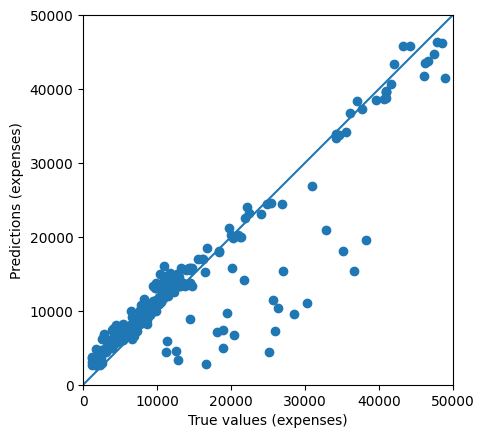

In [10]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
# loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()
# test_predictions = scaler.inverse_transform(pd.DataFrame(test_predictions))
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
